# Traning

Traning Spaceship-Titanic model.

This notebook will use MLflow to track the model training process.

## Data

Note: the `train.csv` is the unique dataset that has the target column (**Transported**).

Because of that, we will split the data into train and test datasets. The test dataset will be used to evaluate the model after training.

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

data = pd.read_csv('data/spaceshit-titanic/train.csv')

X, y = data.drop('Transported', axis=1), data['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)


## Pipeline building

In [2]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline   import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

## 1. Columns separation
# Categorical columns
categorical_columns = [
    'Group', # it will be created by the passenger_id_spliter
    'Deck', # it will be created by the cabin_spliter
    'Num', # it will be created by the cabin_spliter
    'Side', # it will be created by the cabin_spliter
    'VIP',
    'CryoSleep',
    'HomePlanet',
    'Destination'
]
# Categorical columns to encode. They have low cardinality
columns_to_encode = [
    'Deck', # it will be created by the cabin_spliter
    'Side', # it will be created by the cabin_spliter
    'VIP',
    'CryoSleep',
    'HomePlanet',
    'Destination'
]

# Numeric columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Added new numeric columns
numeric_columns.extend([
    'Group', # it will be created by the passenger_id_spliter
    'Num' # it will be created by the cabin_spliter
])

## 2. FunctionTransformers. Custom transformers for columns
# Function
def passenger_id_spliter(passenger_id_col: pd.Series) -> pd.DataFrame:
    '''Function to split the passenger id into two columns

    Args:
        passenger_id_col: pd.Series - The passenger id column

    Returns:
        pd.DataFrame - The dataframe with the two columns (Group, Number)
    '''
    df = (
        pd.DataFrame(
            passenger_id_col
            .str
            .split('_')
            .to_list(),
        columns=['Group', 'Number'],
        index=passenger_id_col.index
        )
        .drop('Number', axis=1)
    )
    return df

def cabin_spliter(cabin_col: pd.Series) -> pd.DataFrame:
    '''Function to split the cabin into two columns

    Args:
        cabin_col: pd.Series - The cabin column

    Returns:
        pd.DataFrame - The dataframe with three columns (Deck, Num, Side)
    '''
    df = (
        cabin_col
        .str
        .split('/', expand=True)
        .rename(columns={0: 'Deck', 1: 'Num', 2: 'Side'})
    )

    return df

## 3. Transformer instantiation

# Custom transformers
passenger_id_transformer = FunctionTransformer(func=passenger_id_spliter,
    feature_names_out=lambda _, __: np.array(['Group'])
)

cabin_transformer = FunctionTransformer(func=cabin_spliter,
    feature_names_out=lambda _, __: np.array(['Deck', 'Num', 'Side'])
)

# Encoders
encoder = OrdinalEncoder()
one_hot = OneHotEncoder()

# Scalers
scaler = StandardScaler()

# Imputer
knn = KNNImputer(n_neighbors=10, weights='uniform')
simple_imputer = SimpleImputer(strategy='median')

# Rounder for the categorical columns
rounder = FunctionTransformer(func=lambda x: np.round(x, 0),
    feature_names_out=lambda _, __: columns_to_encode
)

## 4. Transformers pipeline

# Columns splitter function transformer
splitter_transformer = ColumnTransformer(
    transformers=[
        ('passenger_id', passenger_id_transformer, 'PassengerId'),
        ('cabin', cabin_transformer, 'Cabin')
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Enconder the categorical columns
encoder_transfomer = ColumnTransformer(
    transformers=[
        ('encoder', encoder, columns_to_encode)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Imputers and dropping high cardinality columns
imputer_transformer = ColumnTransformer(
    transformers=[
        ('numeric_imputer', simple_imputer, numeric_columns),
        ('categorical_imputer', knn, columns_to_encode)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Rounder and scalers
rounder_scaler_transformer = ColumnTransformer(
    transformers=[
        ('rounder', rounder, columns_to_encode),
        ('scaler', scaler, numeric_columns)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Dropping columns
drop_columns_transformer = ColumnTransformer(
    transformers=[
        ('drop', 'drop', 'Name')
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Gather all transformers into a pipeline
transfomers = Pipeline([
    ('splitter', splitter_transformer),
    ('encoder', encoder_transfomer),
    ('imputer', imputer_transformer),
    ('rounder_scaler', rounder_scaler_transformer),
    ('drop_columns', drop_columns_transformer)
])

# Garantee that the output of "transform" and "fit_transform" will be a pandas dataframe
# This is necessary due use label columns into transformers
transfomers.set_output(transform='pandas')

# Estimator to predict.
# Use a VotingClassifier to ensemble different models
nn = MLPClassifier(hidden_layer_sizes=(50, 5), activation='relu', max_iter=1000, random_state=42)
logistic = LogisticRegression(random_state=42)
random_forest = RandomForestClassifier(random_state=42)

clfs = VotingClassifier(estimators=[
    ('nn', nn),
    ('logistic', logistic),
    ('random_forest', random_forest)
], voting='soft')

# Pipeline
clf = Pipeline([
    ('estimator', clfs)
])

# 5. Final pipeline
pipe = Pipeline([
    ('transformers', transfomers),
    ('clf', clf)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('transformers',
                 Pipeline(steps=[('splitter',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    remainder='passthrough',
                                                    transformers=[('passenger_id',
                                                                   FunctionTransformer(feature_names_out=<function <lambda> at 0x00000200EAFAB560>,
                                                                                       func=<function passenger_id_spliter at 0x00000200C10DCE00>),
                                                                   'PassengerId'),
                                                                  ('cabin',
                                                                   FunctionTransformer(feature_n...
                                                    remainder='passthrough',
                                                    transformers=[('drop',
                                                                   'drop',
                                                                   'Name')],
                                                    verbose_feature_names_out=False))])),
                ('clf',
                 Pipeline(steps=[('estimator',
                                  VotingClassifier(estimators=[('nn',
                                                                MLPClassifier(hidden_layer_sizes=(50,
                                                                                                  5),
                                                                              max_iter=1000,
                                                                              random_state=42)),
                                                               ('logistic',
                                                                LogisticRegression(random_state=42)),
                                                               ('random_forest',
                                                                RandomForestClassifier(random_state=42))],
                                                   voting='soft'))]))])

## Evaluating

In [3]:
from sklearn.metrics import (
    roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, 
    precision_recall_curve, PrecisionRecallDisplay, f1_score, accuracy_score,
    recall_score, precision_score
)
from sklearn.model_selection import cross_val_score, cross_validate
import matplotlib.pyplot as plt
import seaborn as sns

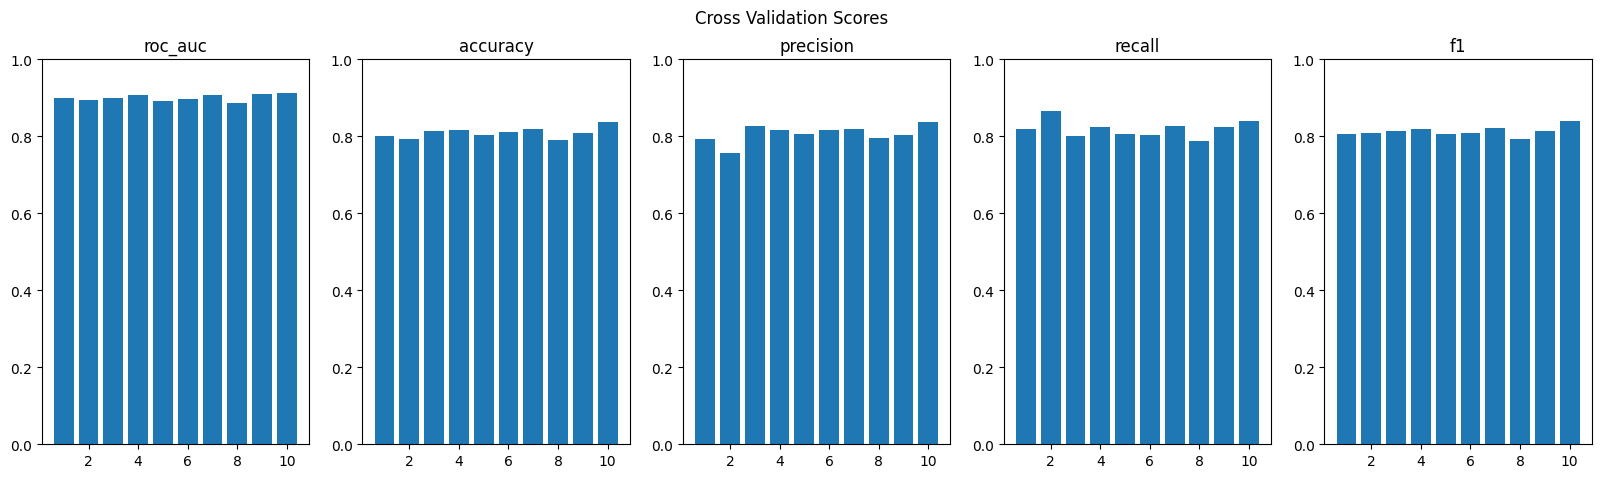

In [4]:
# Cross Validation
cv = cross_validate(pipe, X_train, y_train, cv=10, return_estimator=True, 
                    scoring=['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
                    )

# Plot the metric scores
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i, metric in enumerate(['roc_auc', 'accuracy', 'precision', 'recall', 'f1']):
    ax[i].bar(range(1, 11), cv[f'test_{metric}'])
    ax[i].set_title(metric)
    ax[i].set_ylim(0, 1)
fig.suptitle('Cross Validation Scores')
plt.show()

In [36]:
# Get the best estimator based in the recall score
predictor = cv['estimator'][np.argmax(cv['test_recall'])]

# Predict the test set with the best estimator
y_pred = predictor.predict(X_test)

-------------------------------------------------- Reporting --------------------------------------------------
Cross Validation Results (mean, std):
ROC AUC:	 0.9004 , 0.008
Accuracy:	 0.8099 , 0.0129
Precision:	 0.8069 , 0.021
Recall:		 0.8194 , 0.021
F1:		 0.8127 , 0.0117

Best Estimator (based in the recall score):
Estimator:
	VotingClassifier(estimators=[('nn',
                              MLPClassifier(hidden_layer_sizes=(100, 10),
                                            max_iter=2000, random_state=42)),
                             ('logistic',
                              LogisticRegression(C=10, random_state=42)),
                             ('random_forest',
                              RandomForestClassifier(max_depth=10,
                                                     random_state=42))],
                 voting='soft')

Evaluation in the test set
ROC AUC:	 0.8905
Accuracy:	 0.797
Precision:	 0.7778
Recall:		 0.8371
F1:		 0.8064



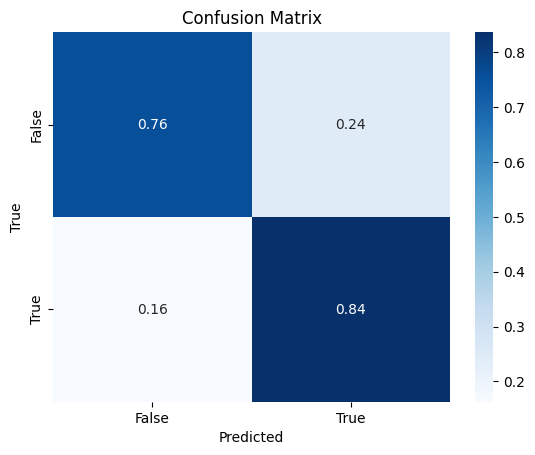

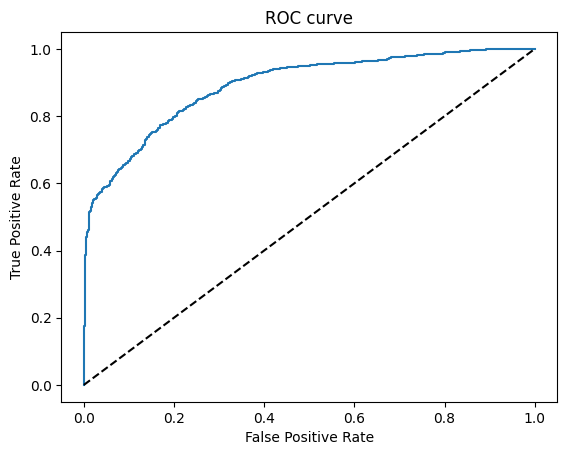

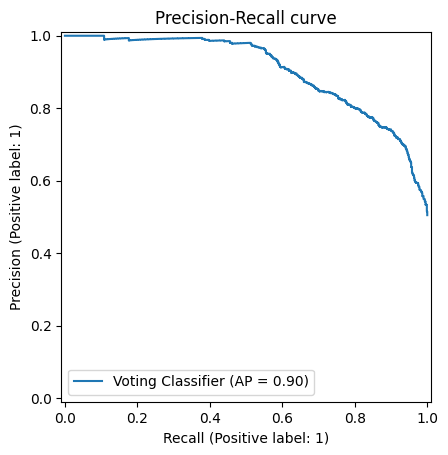

In [35]:
# Infos
print('-'*50, 'Reporting', '-'*50)

# Cross validation results
print('Cross Validation Results (mean, std):')
print(f'ROC AUC:\t {cv["test_roc_auc"].mean().round(4)} , {cv["test_roc_auc"].std().round(4)}')
print(f'Accuracy:\t {cv["test_accuracy"].mean().round(4)} , {cv["test_accuracy"].std().round(4)}')
print(f'Precision:\t {cv["test_precision"].mean().round(4)} , {cv["test_precision"].std().round(4)}')
print(f'Recall:\t\t {cv["test_recall"].mean().round(4)} , {cv["test_recall"].std().round(4)}')
print(f'F1:\t\t {cv["test_f1"].mean().round(4)} , {cv["test_f1"].std().round(4)}\n')



# Best estimator
print('Best Estimator (based in the recall score):')
print(f'Estimator:\n\t{predictor.named_steps["clf"].named_steps["estimator"]}\n')

# Evaluation in the test set
print('Evaluation in the test set')
print(f'ROC AUC:\t {roc_auc_score(y_test, predictor.predict_proba(X_test)[:, 1]).round(4)}')
print(f'Accuracy:\t {round(accuracy_score(y_test, y_pred), 4)}')
print(f'Precision:\t {round(precision_score(y_test, y_pred), 4)}') #type: ignore
print(f'Recall:\t\t {round(recall_score(y_test, y_pred), 4)}') #type: ignore
print(f'F1:\t\t {round(f1_score(y_test, y_pred), 4)}\n') #type: ignore

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=predictor.classes_, 
            yticklabels=predictor.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, predictor.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# Precision Recall Curve
disp = PrecisionRecallDisplay.from_estimator(predictor, X_test, y_test, name='Voting Classifier', pos_label=1)
_ = disp.ax_.set_title('Precision-Recall curve')

# Hyperparameters tuning

For hyperparameters tuning, the strategy will be to use a set of values either to transformer/estimators hyperparameters and the transformer/estimatores objects itself.

For instance, the transformer for imput values into numeric columns would be changed to `KNNImputer` or a `FunctionTransformer` with a custom function.

Theses ways of tuning will be done using `GridSearchCV` and `RandomizedSearchCV` from `sklearn.model_selection`.

## Pipeline building for hyperparameters tuning

In [ ]:
# Setting the parameter grid
param_grid = {
    'transformers__rounder_scaler__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
    'transformers__imputer__numeric_imputer__strategy': ['mean', 'median'],
    'transformers__imputer__categorical_imputer__n_neighbors': [5, 10, 15],
    'clf__estimator__nn__hidden_layer_sizes': [(50, 5), (100, 10), (50, 50, 5)],
    'clf__estimator__nn__activation': ['relu', 'tanh', 'logistic'],
    'clf__estimator__nn__max_iter': [1000, 2000],
    'clf__estimator__logistic__C': [0.1, 1, 10],
    'clf__estimator__random_forest__n_estimators': [100, 200, 300],
    'clf__estimator__random_forest__max_depth': [5, 10, 15]
}

from sklearn.model_selection import RandomizedSearchCV

# grid = GridSearchCV(pipe, param_grid, cv=5, scoring='recall', n_jobs=-1)

grid = RandomizedSearchCV(pipe, param_grid, cv=5, scoring='f1', n_jobs=-1, n_iter=100)

In [18]:
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformers',
                                              Pipeline(steps=[('splitter',
                                                               ColumnTransformer(force_int_remainder_cols=False,
                                                                                 remainder='passthrough',
                                                                                 transformers=[('passenger_id',
                                                                                                FunctionTransformer(feature_names_out=<function <lambda> at 0x00000200EAFAB560>,
                                                                                                                    func=<function passenger_id_spliter at 0x00000200C10DCE00>),
                                                                                                'PassengerId'),
                                                                                               ('ca...
                                        'clf__estimator__random_forest__max_depth': [5,
                                                                                     10,
                                                                                     15],
                                        'clf__estimator__random_forest__n_estimators': [100,
                                                                                        200,
                                                                                        300],
                                        'transformers__imputer__categorical_imputer__n_neighbors': [5,
                                                                                                    10,
                                                                                                    15],
                                        'transformers__imputer__numeric_imputer__strategy': ['mean',
                                                                                             'median'],
                                        'transformers__rounder_scaler__scaler': [StandardScaler(),
                                                                                 RobustScaler(),
                                                                                 MinMaxScaler()]},
                   scoring='recall')

In [34]:
# Get the best estimator based in the recall score
predictor = grid.best_estimator_

# Predict the test set with the best estimator
y_pred = predictor.predict(X_test)

-------------------------------------------------- Reporting --------------------------------------------------
Grid Cross Validation Results (mean, std):
Metric:		 0.809 , 0.0147

Best Parameters:
transformers__rounder_scaler__scaler: StandardScaler()
transformers__imputer__numeric_imputer__strategy: mean
transformers__imputer__categorical_imputer__n_neighbors: 10
clf__estimator__random_forest__n_estimators: 100
clf__estimator__random_forest__max_depth: 10
clf__estimator__nn__max_iter: 2000
clf__estimator__nn__hidden_layer_sizes: (100, 10)
clf__estimator__nn__activation: relu
clf__estimator__logistic__C: 10

Best Estimator (based in the recall score):
Estimator:
	VotingClassifier(estimators=[('nn',
                              MLPClassifier(hidden_layer_sizes=(100, 10),
                                            max_iter=2000, random_state=42)),
                             ('logistic',
                              LogisticRegression(C=10, random_state=42)),
                       

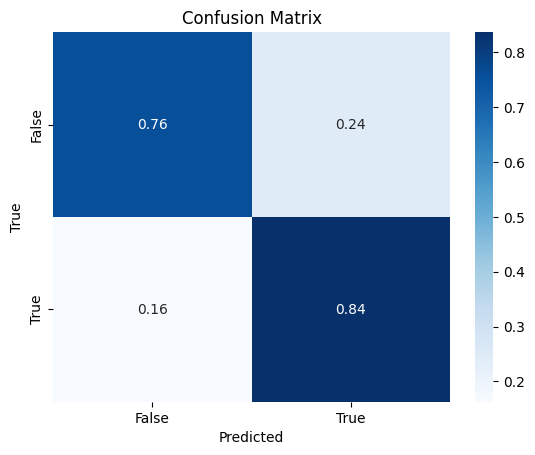

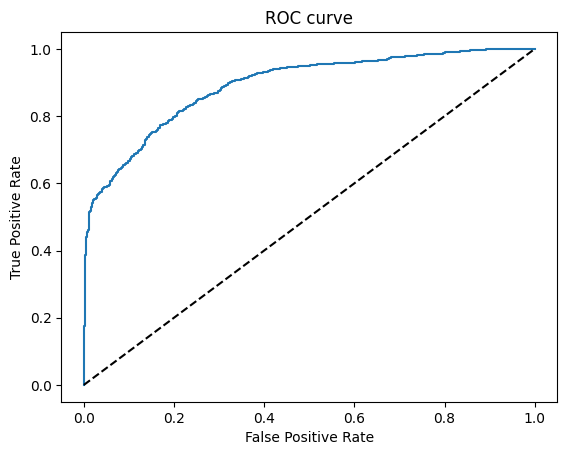

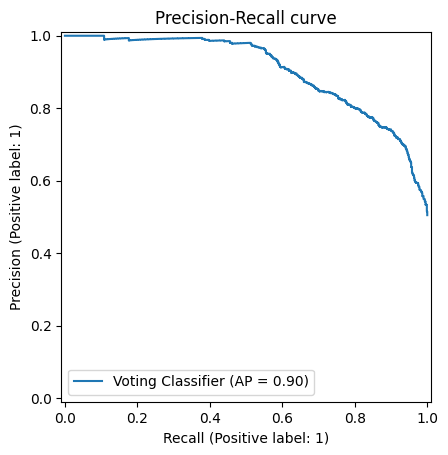

In [33]:
# Infos
print('-'*50, 'Reporting', '-'*50)

# Cross validation results
print('Grid Cross Validation Results (mean, std):')
print(f'Metric:\t\t {grid.cv_results_["mean_test_score"].mean().round(4)} , {grid.cv_results_["std_test_score"].mean().round(4)}\n')

# Best parameters
print('Best Parameters:')
for key, value in grid.best_params_.items():
    print(f'{key}: {value}')

# Best estimator
print('\nBest Estimator (based in the recall score):')
print(f'Estimator:\n\t{predictor.named_steps['clf'].named_steps['estimator']}\n')

# Evaluation in the test set
print('Evaluation in the test set')
print(f'ROC AUC:\t {roc_auc_score(y_test, predictor.predict_proba(X_test)[:, 1]).round(4)}')
print(f'Accuracy:\t {round(accuracy_score(y_test, y_pred), 4)}')
print(f'Precision:\t {round(precision_score(y_test, y_pred), 4)}') #type: ignore
print(f'Recall:\t\t {round(recall_score(y_test, y_pred), 4)}') #type: ignore
print(f'F1:\t\t {round(f1_score(y_test, y_pred), 4)}\n') #type: ignore

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=predictor.classes_, 
            yticklabels=predictor.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, predictor.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# Precision Recall Curve
disp = PrecisionRecallDisplay.from_estimator(predictor, X_test, y_test, name='Voting Classifier', pos_label=1)
_ = disp.ax_.set_title('Precision-Recall curve')